In [1]:
import os

import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from matplotlib import rc
from matplotlib.font_manager import fontManager
from pathlib import Path
from fd_analysis.prepare import *
from collections import defaultdict

%matplotlib inline

In [2]:
font_path = "/usr/local/share/fonts/Virgil.ttf"

# Register the font
fontManager.addfont(font_path)
font = {"family": "Virgil 3 YOFF"}

# Import data


In [3]:
paths_biomed = "../data/results_biomed_20240423/"

data_biomed, corrupt_biomed = filter_corrupt_files(
    [Path(paths_biomed) / file for file in os.listdir(paths_biomed)]
)

print("Corrupt: ", corrupt_biomed)
len(data_biomed)

Corrupt:  []


1818

In [4]:
paths_pypi = "../data/results_pypi_20240423/"

data_pypi, corrupt_pypi = filter_corrupt_files(
    [Path(paths_pypi) / file for file in os.listdir(paths_pypi)]
)

print("Corrupt: ", corrupt_pypi)
len(data_pypi)

Corrupt:  []


1160

In [5]:
data_biomed["markerGeneProfile.json"]

{'metadata': {'project_name': 'markerGeneProfile',
  'fawltydeps_version': '0.13.1.1',
  'repo_url': 'https://:@github.com/PavlidisLab/markerGeneProfile.git',
  'creation_timestamp': '2024-04-23T15:56:58.527634'},
 'code_dirs': None,
 'deps_file': [],
 'imports': []}

# Code structure


In [11]:
df_codedirs_biomed = get_python_projects_df(data_biomed)
python_projects_biomed = get_python_projects(df_codedirs_biomed)

In [12]:
df_codedirs_pypi = get_python_projects_df(data_pypi)
python_projects_pypi = get_python_projects(df_codedirs_pypi)

In [13]:
len(python_projects_biomed), len(python_projects_pypi)

(1260, 1118)

In [14]:
df_codedirs_biomed.head(), df_codedirs_pypi.head()

(           darkflow/dark       darkflow/utils       darkflow/net        \
                       py ipynb             py ipynb           py ipynb   
 darkflow             6.0   0.0            6.0   0.0          5.0   0.0   
 encode2bag           NaN   NaN            NaN   NaN          NaN   NaN   
 osmosis              NaN   NaN            NaN   NaN          NaN   NaN   
 brian2genn           NaN   NaN            NaN   NaN          NaN   NaN   
 yeadon               NaN   NaN            NaN   NaN          NaN   NaN   
 
            darkflow/net/yolo       darkflow/net/yolov2        ...  \
                           py ipynb                  py ipynb  ...   
 darkflow                 5.0   0.0                 4.0   0.0  ...   
 encode2bag               NaN   NaN                 NaN   NaN  ...   
 osmosis                  NaN   NaN                 NaN   NaN  ...   
 brian2genn               NaN   NaN                 NaN   NaN  ...   
 yeadon                   NaN   NaN                 N

In [15]:
codedirs_py_biomed = df_codedirs_biomed.xs("py", level=1, axis=1)
codedirs_ipynb_biomed = df_codedirs_biomed.xs("ipynb", level=1, axis=1)
codedirs_sum_biomed = codedirs_py_biomed + codedirs_ipynb_biomed

codedirs_py_pypi = df_codedirs_pypi.xs("py", level=1, axis=1)
codedirs_ipynb_pypi = df_codedirs_pypi.xs("ipynb", level=1, axis=1)
codedirs_sum_pypi = codedirs_py_pypi + codedirs_ipynb_pypi

In [16]:
drop_cols_biomed = [
    col
    for col in codedirs_sum_biomed.columns
    if "test" in col.lower()
    or "example" in col.lower()
    or "sample" in col.lower()
    or "doc" in col.lower()
    or "tutorial" in col.lower()
]

drop_cols_pypi = [
    col
    for col in codedirs_sum_pypi.columns
    if "test" in col.lower()
    or "example" in col.lower()
    or "sample" in col.lower()
    or "doc" in col.lower()
    or "tutorial" in col.lower()
]

In [17]:
codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns=drop_cols_biomed).idxmax(
    axis=1
)
codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns=drop_cols_pypi).idxmax(axis=1)

/tmp/ipykernel_1527757/4160416966.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_biomed = codedirs_sum_biomed.drop(columns=drop_cols_biomed).idxmax(
/tmp/ipykernel_1527757/4160416966.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  codedirs_sum_main_pypi = codedirs_sum_pypi.drop(columns=drop_cols_pypi).idxmax(axis=1)


In [18]:
codedirs_sum_main_biomed, codedirs_sum_main_pypi

(darkflow                  darkflow/dark
 encode2bag                 PROJECT_NAME
 osmosis                   osmosis/ipynb
 brian2genn                 PROJECT_NAME
 yeadon                     PROJECT_NAME
                         ...            
 diffusion                           NaN
 nextmed               src visualization
 ReproPhylo                 Galaxy_tools
 x2k_web       src/main/webapp/notebooks
 deep-rules               content/images
 Length: 1260, dtype: object,
 jupyter_ydoc                                                       PROJECT_NAME
 jira                                                               PROJECT_NAME
 rasterio                                                           PROJECT_NAME
 pygit2                                                             PROJECT_NAME
 Box                                                                PROJECT_NAME
                                                     ...                        
 ApplicationInsights-Python    az

In [19]:
same_name_projects_biomed = set(
    [k for k, v in codedirs_sum_main_biomed.items() if v == "PROJECT_NAME"]
)
src_projects_biomed = set(
    [
        k
        for k, v in codedirs_sum_main_biomed.items()
        if not v != v and v.startswith("src")
    ]
)
root_dir_projects_biomed = set(
    [k for k, v in codedirs_sum_main_biomed.items() if v == "."]
)
rest_projects_biomed = (
    python_projects_biomed
    - same_name_projects_biomed
    - src_projects_biomed
    - root_dir_projects_biomed
)

same_name_projects_pypi = set(
    [k for k, v in codedirs_sum_main_pypi.items() if v == "PROJECT_NAME"]
)
src_projects_pypi = set(
    [k for k, v in codedirs_sum_main_pypi.items() if not v != v and v.startswith("src")]
)
root_dir_projects_pypi = set([k for k, v in codedirs_sum_main_pypi.items() if v == "."])
rest_projects_pypi = (
    python_projects_pypi
    - same_name_projects_pypi
    - src_projects_pypi
    - root_dir_projects_pypi
)

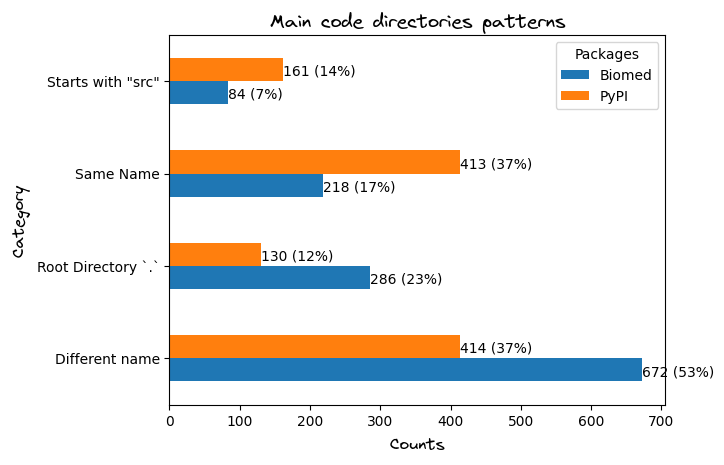

In [20]:
plot_data_biomed = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_biomed),
            len(src_projects_biomed),
            len(rest_projects_biomed),
            len(root_dir_projects_biomed),
        ],
        "Percentage": [0.25, 0.25, 0.25, 0.25],
    }
)
plot_data_pypi = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Counts": [
            len(same_name_projects_pypi),
            len(src_projects_pypi),
            len(rest_projects_pypi),
            len(root_dir_projects_pypi),
        ],
        "Percentage": [0.25, 0.25, 0.25, 0.25],
    }
)

plot_data_biomed["Group"] = "Biomed"
plot_data_pypi["Group"] = "PyPI"

plot_data = pd.concat([plot_data_biomed, plot_data_pypi])
grouped_data = plot_data.groupby(["Group", "Category"]).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(index="Category", columns="Group", values="Counts")

# Plotting
ax = pivot_table.plot(kind="barh")
plt.xlabel("Counts", fontname="Virgil 3 YOFF", fontsize=12)
plt.ylabel("Category", fontname="Virgil 3 YOFF", fontsize=12)
plt.title("Main code directories patterns", fontname="Virgil 3 YOFF", fontsize=14)
plt.legend(title="Packages")
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if ax.patches.index(p) < 4:
        ax.annotate(
            f"{width} ({width/len(python_projects_biomed):.0%})",
            (x + width, y + height / 4),
        )
    else:
        ax.annotate(
            f"{width} ({width/len(python_projects_pypi):.0%})",
            (x + width, y + height / 4),
        )
plt.savefig("code_structure.png", dpi=600, bbox_inches="tight")
plt.show()

# Dependency declarations


In [17]:
depsfiles_biomed = get_depsfiles(data_biomed)
depsfiles_pypi = get_depsfiles(data_pypi)

732
1117


In [18]:
project_with_deps_biomed = set()
for project_name, depsfile in depsfiles_biomed.items():
    for dep in depsfile:
        if dep["parser_choice"] == "requirements.txt" or dep["deps_count"] > 0:
            project_with_deps_biomed.add(project_name)
            break

project_with_deps_pypi = set()
for project_name, depsfile in depsfiles_pypi.items():
    for dep in depsfile:
        if dep["parser_choice"] == "requirements.txt" or dep["deps_count"] > 0:
            project_with_deps_pypi.add(project_name)
            break

In [19]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val) if pct > 0 else ""

    return my_format

In [22]:
dep_counts_biomed = np.array(
    [len(depsfiles_biomed), len(python_projects_biomed) - len(depsfiles_biomed)]
)
dep_counts_pypi = np.array(
    [len(depsfiles_pypi), len(python_projects_pypi) - len(depsfiles_pypi)]
)

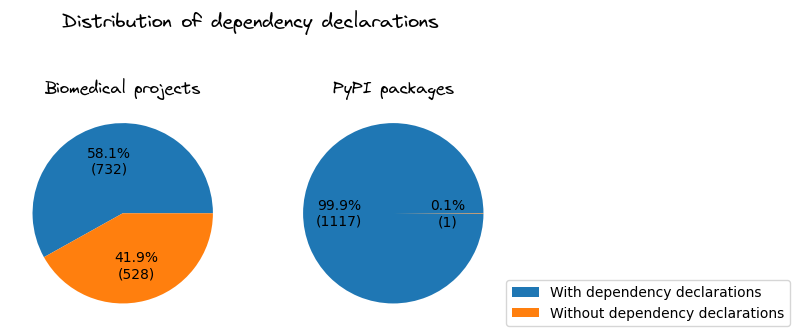

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Distribution of dependency declarations", fontname="Virgil 3 YOFF", fontsize=14
)
ax1.pie(dep_counts_biomed, autopct=autopct_format(dep_counts_biomed))
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(dep_counts_pypi, autopct=autopct_format(dep_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(
    loc=(1, 0),
    labels=["With dependency declarations", "Without dependency declarations"],
)
plt.subplots_adjust(top=1)
plt.savefig("distribution_deps_1.png", dpi=600, bbox_inches="tight")

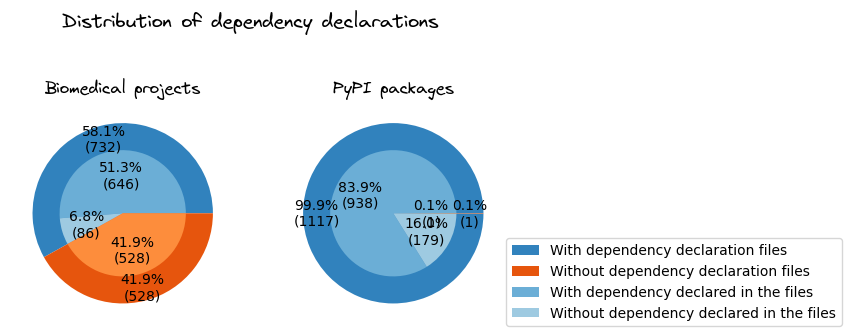

In [26]:
dep_counts_biomed_nested = np.array(
    [
        [
            len(project_with_deps_biomed),
            len(depsfiles_biomed) - len(project_with_deps_biomed),
        ],
        [len(python_projects_biomed) - len(depsfiles_biomed), 0],
    ]
)
dep_counts_pypi_nested = np.array(
    [
        [
            len(project_with_deps_pypi),
            len(depsfiles_pypi) - len(project_with_deps_pypi),
        ],
        [len(python_projects_pypi) - len(depsfiles_pypi), 0],
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2)

size = 0.3
cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(2) * 4)
inner_colors = cmap([1, 2, 5, 6])

ax1.pie(
    dep_counts_biomed_nested.sum(axis=1),
    radius=1,
    colors=outer_colors,
    autopct=autopct_format(dep_counts_biomed_nested.sum(axis=1)),
    pctdistance=0.85,
)

ax1.pie(
    dep_counts_biomed_nested.flatten(),
    radius=1 - size,
    colors=inner_colors,
    autopct=autopct_format(dep_counts_biomed_nested.flatten()),
    pctdistance=0.6,
)


ax2.pie(
    dep_counts_pypi_nested.sum(axis=1),
    radius=1,
    colors=outer_colors,
    autopct=autopct_format(dep_counts_pypi_nested.sum(axis=1)),
    pctdistance=0.85,
)

ax2.pie(
    dep_counts_pypi_nested.flatten(),
    radius=1 - size,
    colors=inner_colors,
    autopct=autopct_format(dep_counts_pypi_nested.flatten()),
    pctdistance=0.6,
)

plt.legend(
    loc=(1, 0),
    labels=[
        "With dependency declaration files",
        "Without dependency declaration files",
        "With dependency declared in the files",
        "Without dependency declared in the files",
    ],
)
plt.title("Dependency declarations", fontname="Virgil 3 YOFF", fontsize=14)
plt.subplots_adjust(top=1)
fig.suptitle(
    "Distribution of dependency declarations", fontname="Virgil 3 YOFF", fontsize=14
)
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)

plt.savefig("distribution_deps_1_new.png", dpi=600, bbox_inches="tight")
plt.show()

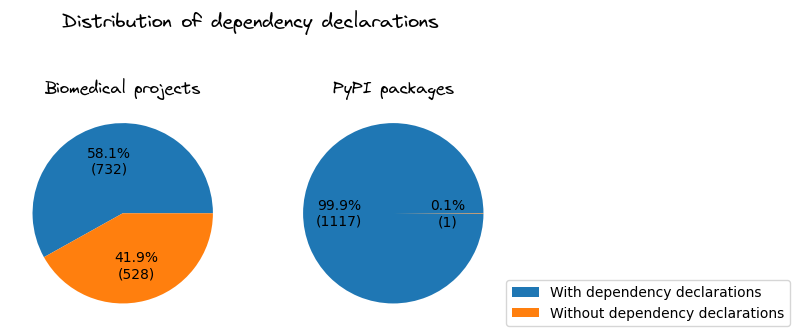

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Distribution of dependency declarations", fontname="Virgil 3 YOFF", fontsize=14
)
ax1.pie(dep_counts_biomed, autopct=autopct_format(dep_counts_biomed))
ax1.set_title("Biomedical projects", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(dep_counts_pypi, autopct=autopct_format(dep_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(
    loc=(1, 0),
    labels=["With dependency declarations", "Without dependency declarations"],
)
plt.subplots_adjust(top=1)
plt.savefig("distribution_deps_1.png", dpi=600, bbox_inches="tight")

In [28]:
project_req_txt = set()
project_pyproject_toml = set()
project_setup = set()

for project_name, deps in depsfiles_biomed.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml" and dep["deps_count"] > 0:
            project_pyproject_toml.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup.add(project_name)
            break

In [29]:
project_req_txt_pypi = set()
project_pyproject_toml_pypi = set()
project_setup_pypi = set()

for project_name, deps in depsfiles_pypi.items():
    for dep in deps:
        if dep["parser_choice"] == "requirements.txt":
            project_req_txt_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"] == "pyproject.toml" and dep["deps_count"] > 0:
            project_pyproject_toml_pypi.add(project_name)
            break
    for dep in deps:
        if dep["parser_choice"].startswith("setup") and dep["deps_count"] > 0:
            project_setup_pypi.add(project_name)
            break

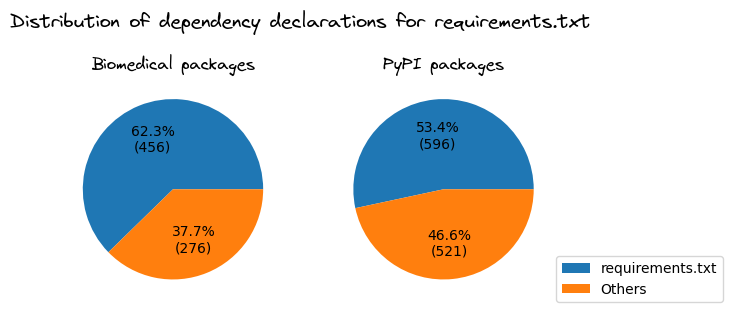

In [30]:
req_txt_counts = np.array(
    [len(project_req_txt), len(depsfiles_biomed) - len(project_req_txt)]
)
req_txt_counts_pypi = np.array(
    [len(project_req_txt_pypi), len(depsfiles_pypi) - len(project_req_txt_pypi)]
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Distribution of dependency declarations for requirements.txt",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
ax1.pie(req_txt_counts, autopct=autopct_format(req_txt_counts))
ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(req_txt_counts_pypi, autopct=autopct_format(req_txt_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["requirements.txt", "Others"])
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.1.png", dpi=600, bbox_inches="tight")

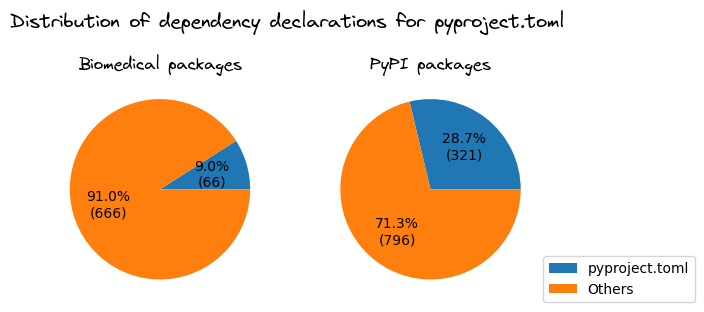

In [31]:
pyproject_toml_counts = np.array(
    [len(project_pyproject_toml), len(depsfiles_biomed) - len(project_pyproject_toml)]
)
pyproject_toml_counts_pypi = np.array(
    [
        len(project_pyproject_toml_pypi),
        len(depsfiles_pypi) - len(project_pyproject_toml_pypi),
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Distribution of dependency declarations for pyproject.toml",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
ax1.pie(pyproject_toml_counts, autopct=autopct_format(pyproject_toml_counts))
ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(pyproject_toml_counts_pypi, autopct=autopct_format(pyproject_toml_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["pyproject.toml", "Others"])
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.2.png", dpi=600, bbox_inches="tight")

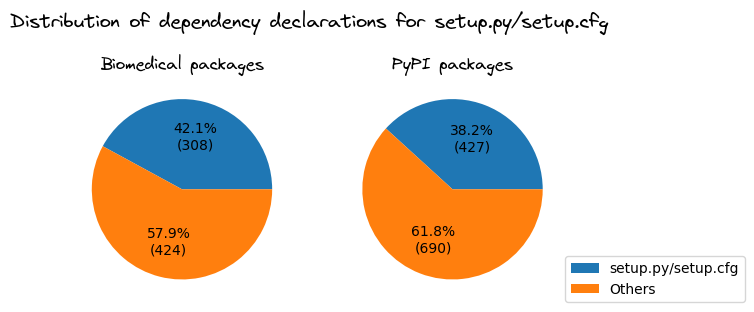

In [32]:
setup_counts = np.array(
    [len(project_setup), len(depsfiles_biomed) - len(project_setup)]
)
setup_counts_pypi = np.array(
    [len(project_setup_pypi), len(depsfiles_pypi) - len(project_setup_pypi)]
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(
    "Distribution of dependency declarations for setup.py/setup.cfg",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
ax1.pie(setup_counts, autopct=autopct_format(setup_counts))
ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.pie(setup_counts_pypi, autopct=autopct_format(setup_counts_pypi))
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12)
plt.legend(loc=(1, 0), labels=["setup.py/setup.cfg", "Others"])
plt.subplots_adjust(top=1.1)
plt.savefig("distribution_deps_2.3.png", dpi=600, bbox_inches="tight")

In [33]:
project_req_only = project_req_txt - project_pyproject_toml - project_setup
project_toml_only = project_pyproject_toml - project_req_txt - project_setup
project_setup_only = project_setup - project_req_txt - project_pyproject_toml
project_req_toml = project_req_txt.intersection(
    project_pyproject_toml
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_setup = project_req_txt.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_toml_setup = project_pyproject_toml.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_toml_setup = project_req_txt.intersection(
    project_pyproject_toml
).intersection(project_setup)
project_no_deps = python_projects_biomed - depsfiles_biomed.keys()

In [34]:
project_req_only_pypi = (
    project_req_txt_pypi - project_pyproject_toml_pypi - project_setup_pypi
)
project_toml_only_pypi = (
    project_pyproject_toml_pypi - project_req_txt_pypi - project_setup_pypi
)
project_setup_only_pypi = (
    project_setup_pypi - project_req_txt_pypi - project_pyproject_toml_pypi
)
project_req_toml_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(
    project_setup_pypi
)
project_req_setup_pypi = project_req_txt_pypi.intersection(
    project_setup_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(
    project_setup_pypi
)
project_toml_setup_pypi = project_pyproject_toml_pypi.intersection(
    project_setup_pypi
) - project_req_txt_pypi.intersection(project_pyproject_toml_pypi).intersection(
    project_setup_pypi
)
project_req_toml_setup_pypi = project_req_txt_pypi.intersection(
    project_pyproject_toml_pypi
).intersection(project_setup_pypi)
project_no_deps_pypi = python_projects_pypi - depsfiles_pypi.keys()

In [35]:
df_deps_count = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only),
            len(project_toml_only),
            len(project_setup_only),
            len(project_req_toml),
            len(project_req_setup),
            len(project_toml_setup),
            len(project_req_toml_setup),
            len(python_projects_biomed) - len(project_with_deps_biomed),
        ],
    )
)

In [36]:
df_deps_count_pypi = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only_pypi),
            len(project_toml_only_pypi),
            len(project_setup_only_pypi),
            len(project_req_toml_pypi),
            len(project_req_setup_pypi),
            len(project_toml_setup_pypi),
            len(project_req_toml_setup_pypi),
            len(python_projects_pypi) - len(project_with_deps_pypi),
        ],
    )
)

In [37]:
desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]

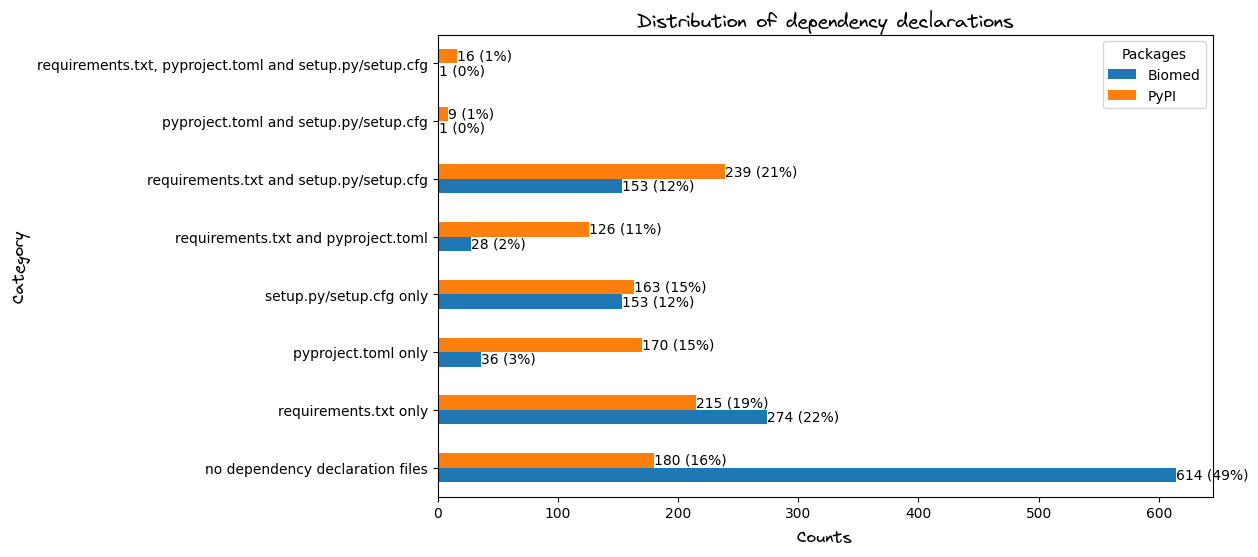

In [38]:
df_deps_count["Group"] = "Biomed"
df_deps_count_pypi["Group"] = "PyPI"
deps_count_combined = pd.concat([df_deps_count, df_deps_count_pypi])
grouped_data = deps_count_combined.groupby(["Group", "type_"]).sum().reset_index()

# Create a pivot table for easier plotting
pivot_table = grouped_data.pivot(
    index="type_", columns="Group", values="count"
).reindex(desired_order)

# Plotting
plt.rcParams["figure.figsize"] = [10, 6]
ax = pivot_table.plot(kind="barh")

plt.xlabel("Counts", fontname="Virgil 3 YOFF", fontsize=12)
plt.ylabel("Category", fontname="Virgil 3 YOFF", fontsize=12)
plt.title(
    "Distribution of dependency declarations", fontname="Virgil 3 YOFF", fontsize=14
)
plt.legend(title="Packages")
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if ax.patches.index(p) < 8:
        ax.annotate(
            f"{width} ({width/len(python_projects_biomed):.0%})",
            (x + width, y + height / 4),
        )
    else:
        ax.annotate(
            f"{width} ({width/len(python_projects_pypi):.0%})",
            (x + width, y + height / 4),
        )
plt.savefig("distribution_deps_3.png", dpi=600, bbox_inches="tight")
plt.show()

6


<Figure size 1000x600 with 0 Axes>

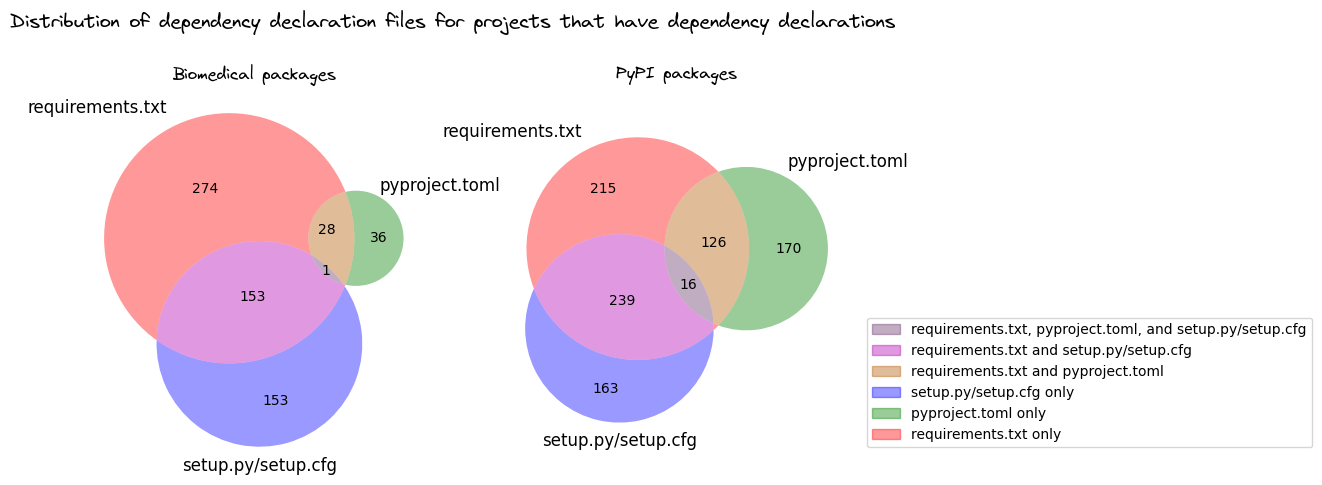

In [45]:
# Draw a venn diagram
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax1,
)

venn_parsers_pypi = venn3(
    [project_req_txt_pypi, project_pyproject_toml_pypi, project_setup_pypi],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax2,
)


# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]

print(len(legend_handles))
order = [5, 4, 2, 3, 1, 0]
plt.legend(handles=[legend_handles[idx] for idx in order], loc=(1.04, 0))
ax1.set_title("Biomedical packages", fontname="Virgil 3 YOFF", fontsize=12)
ax2.set_title("PyPI packages", fontname="Virgil 3 YOFF", fontsize=12, y=1.08)

plt.suptitle(
    "Distribution of dependency declaration files for projects that have dependency declarations",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.subplots_adjust(top=0.95)

plt.savefig("distribution_deps_4.png", dpi=600, bbox_inches="tight")

# Dependency declaration & code structure


In [46]:
conditions = [
    (codedirs_sum_main_biomed.index.isin(project_dep))
    for project_dep in [
        project_req_only,
        project_toml_only,
        project_setup_only,
        project_req_toml,
        project_req_setup,
        project_toml_setup,
        project_req_toml_setup,
        project_no_deps,
    ]
]
# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]

codedirs_sum_main_biomed = pd.DataFrame(codedirs_sum_main_biomed)
codedirs_sum_main_biomed["deps"] = np.select(conditions, values)
codedirs_sum_main_biomed["deps"] = pd.Categorical(
    codedirs_sum_main_biomed["deps"], categories=desired_order, ordered=True
)

In [47]:
conditions_pypi = [
    (codedirs_sum_main_pypi.index.isin(project_dep))
    for project_dep in [
        project_req_only_pypi,
        project_toml_only_pypi,
        project_setup_only_pypi,
        project_req_toml_pypi,
        project_req_setup_pypi,
        project_toml_setup_pypi,
        project_req_toml_setup_pypi,
        project_no_deps_pypi,
    ]
]
codedirs_sum_main_pypi = pd.DataFrame(codedirs_sum_main_pypi)
codedirs_sum_main_pypi["deps"] = np.select(conditions_pypi, values)
codedirs_sum_main_pypi["deps"] = pd.Categorical(
    codedirs_sum_main_pypi["deps"], categories=desired_order, ordered=True
)

In [48]:
codedirs_sum_main_biomed.head(), codedirs_sum_main_pypi.head()

(                        0                                     deps
 darkflow    darkflow/dark                    requirements.txt only
 encode2bag   PROJECT_NAME                  setup.py/setup.cfg only
 osmosis     osmosis/ipynb                                      NaN
 brian2genn   PROJECT_NAME                      pyproject.toml only
 yeadon       PROJECT_NAME  requirements.txt and setup.py/setup.cfg,
                          0                                     deps
 jupyter_ydoc  PROJECT_NAME                      pyproject.toml only
 jira          PROJECT_NAME                      pyproject.toml only
 rasterio      PROJECT_NAME                    requirements.txt only
 pygit2        PROJECT_NAME  requirements.txt and setup.py/setup.cfg
 Box           PROJECT_NAME  requirements.txt and setup.py/setup.cfg)

In [49]:
codedirs_sum_biomed.head()

,darkflow/dark,darkflow/utils,darkflow/net,darkflow/net/yolo,darkflow/net/yolov2,darkflow/net/ops,PROJECT_NAME,darkflow/net/vanilla,test,darkflow/net/mnist,...,layer_runs2/n_message_6,layer_runs2/n_message_1,layer_runs2/n_message_7,layer_runs2/n_message_8,layer_runs2/n_message_9,layer_runs2/n_message_2,layer_runs2/n_message_4,layer_runs2/n_message_10,layer_runs2/n_message_3,20190909_figure4
darkflow,6.0,6.0,5.0,5.0,4.0,4.0,4.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encode2bag,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
osmosis,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brian2genn,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yeadon,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
codedirs_sum_main_biomed["count"] = [
    (
        codedirs_sum_biomed.loc[idx][codedirs_sum_main_biomed[0].loc[idx]]
        if type(codedirs_sum_main_biomed[0].loc[idx]) == str
        else 0.0
    )
    for idx in codedirs_sum_biomed.index
]
codedirs_sum_main_pypi["count"] = [
    (
        codedirs_sum_pypi.loc[idx][codedirs_sum_main_pypi[0].loc[idx]]
        if type(codedirs_sum_main_pypi[0].loc[idx]) == str
        else 0.0
    )
    for idx in codedirs_sum_pypi.index
]

In [51]:
codedirs_ipynb_biomed.sum(axis=1)

darkflow       0.0
encode2bag     0.0
osmosis       80.0
brian2genn     0.0
yeadon         1.0
              ... 
diffusion      0.0
nextmed        0.0
ReproPhylo    19.0
x2k_web        1.0
deep-rules     1.0
Length: 1260, dtype: float64

In [52]:
codedirs_sum_main_biomed[".ipynb count"] = codedirs_ipynb_biomed.sum(axis=1)
codedirs_sum_main_biomed[".ipynb count"] = codedirs_sum_main_biomed[
    ".ipynb count"
].fillna(0)

In [54]:
codedirs_sum_main_biomed[".ipynb>0"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] > 0, True, False
)
codedirs_sum_main_biomed[".ipynb>=5"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 5, True, False
)
codedirs_sum_main_biomed[".ipynb>=10"] = np.where(
    codedirs_sum_main_biomed[".ipynb count"] >= 10, True, False
)

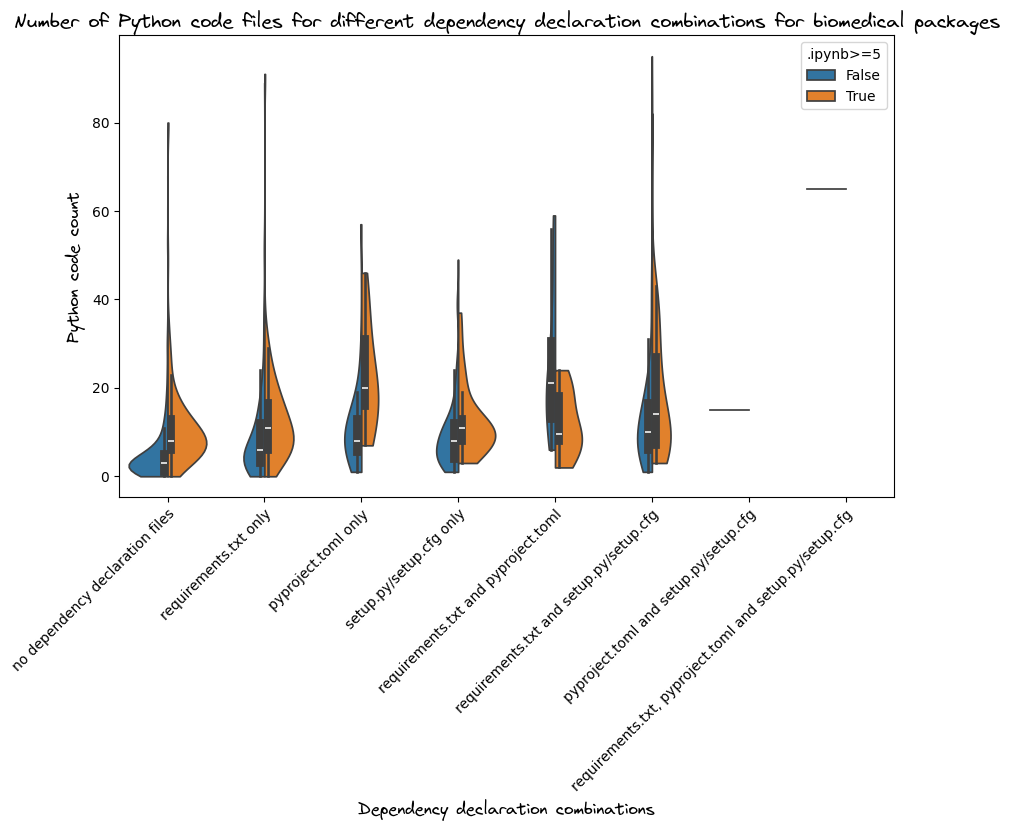

In [55]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=5",
    data=codedirs_sum_main_biomed[codedirs_sum_main_biomed["count"] < 100],
    split=True,
    cut=0,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "Number of Python code files for different dependency declaration combinations for biomedical packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("Dependency declaration combinations", fontname="Virgil 3 YOFF", fontsize=12)
plt.ylabel("Python code count", fontname="Virgil 3 YOFF", fontsize=12)
plt.savefig("correlation_biomed_1.png", dpi=600, bbox_inches="tight")

In [56]:
codedirs_sum_main_pypi[".ipynb count"] = codedirs_ipynb_pypi.sum(axis=1)
codedirs_sum_main_pypi[".ipynb count"] = codedirs_sum_main_pypi[".ipynb count"].fillna(
    0
)

In [59]:
codedirs_sum_main_pypi[".ipynb>0"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] > 0, True, False
)
codedirs_sum_main_pypi[".ipynb>=5"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 5, True, False
)
codedirs_sum_main_pypi[".ipynb>=10"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 10, True, False
)
codedirs_sum_main_pypi[".ipynb>=15"] = np.where(
    codedirs_sum_main_pypi[".ipynb count"] >= 15, True, False
)

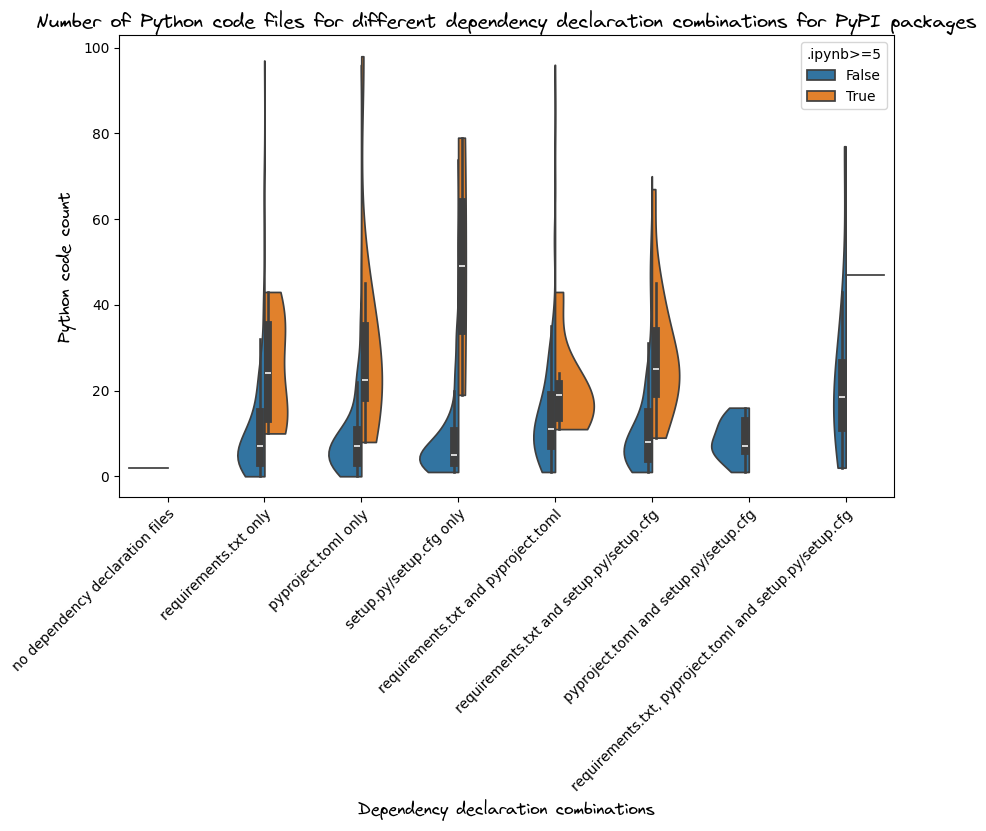

In [60]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=5",
    data=codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100],
    split=True,
    cut=0,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "Number of Python code files for different dependency declaration combinations for PyPI packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("Dependency declaration combinations", fontname="Virgil 3 YOFF", fontsize=12)
plt.ylabel("Python code count", fontname="Virgil 3 YOFF", fontsize=12)
plt.savefig("correlation_pypi_1.png", dpi=600, bbox_inches="tight")

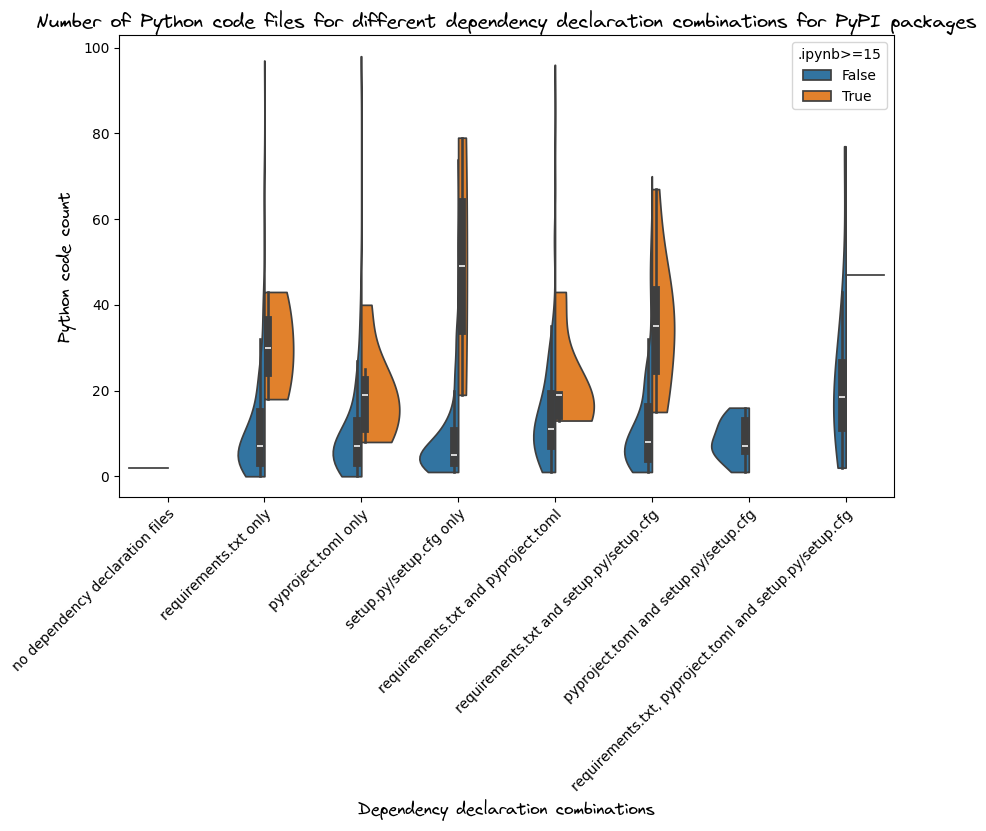

In [61]:
ax = sns.violinplot(
    y="count",
    x="deps",
    hue=".ipynb>=15",
    data=codedirs_sum_main_pypi[codedirs_sum_main_pypi["count"] < 100],
    split=True,
    cut=0,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(
    "Number of Python code files for different dependency declaration combinations for PyPI packages",
    fontname="Virgil 3 YOFF",
    fontsize=14,
)
plt.xlabel("Dependency declaration combinations", fontname="Virgil 3 YOFF", fontsize=12)
plt.ylabel("Python code count", fontname="Virgil 3 YOFF", fontsize=12)
plt.savefig("correlation_pypi_2.png", dpi=600, bbox_inches="tight")

In [63]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi[0] == "."]

,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
schedule,.,requirements.txt only,2.0,0.0,False,False,False,False
thinc,.,requirements.txt only,2.0,0.0,False,False,False,False
aiodns,.,setup.py/setup.cfg only,3.0,0.0,False,False,False,False
hstspreload,.,NaN,4.0,0.0,False,False,False,False
snuggs,.,setup.py/setup.cfg only,2.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...
imagesize_py,.,NaN,2.0,0.0,False,False,False,False
schema,.,requirements.txt only,3.0,0.0,False,False,False,False
appdirs,.,NaN,2.0,0.0,False,False,False,False
python-json-pointer,.,requirements.txt only,3.0,0.0,False,False,False,False


In [64]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt only"][
    codedirs_sum_main_pypi[".ipynb count"] >= 5
]

/tmp/ipykernel_1379051/3241699963.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt only"][codedirs_sum_main_pypi[".ipynb count"] >= 5 ]


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
pynndescent,PROJECT_NAME,requirements.txt only,10.0,6.0,True,True,False,False
great_expectations,contrib/great_expectations_semantic_types_expe...,requirements.txt only,115.0,30.0,True,True,True,True
statsmodels,statsmodels/stats,requirements.txt only,43.0,77.0,True,True,True,True
tensorboard,PROJECT_NAME,requirements.txt only,34.0,11.0,True,True,True,False
arviz,arviz/plots,requirements.txt only,30.0,19.0,True,True,True,True
papermill,PROJECT_NAME,requirements.txt only,18.0,28.0,True,True,True,True
umap,PROJECT_NAME,requirements.txt only,11.0,10.0,True,True,True,False
io,tensorflow_io/python/ops,requirements.txt only,39.0,14.0,True,True,True,False
pyramid,pmdarima/datasets,requirements.txt only,14.0,5.0,True,True,False,False


In [65]:
codedirs_sum_main_pypi[
    codedirs_sum_main_pypi["deps"] == "requirements.txt and pyproject.toml"
][codedirs_sum_main_pypi[".ipynb count"] >= 5]

/tmp/ipykernel_1379051/956514154.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt and pyproject.toml"][codedirs_sum_main_pypi[".ipynb count"] >= 5 ]


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
gradio,gradio/components,requirements.txt and pyproject.toml,43.0,254.0,True,True,True,True
shap,shap/plots,requirements.txt and pyproject.toml,19.0,87.0,True,True,True,True
flax,flax/linen,requirements.txt and pyproject.toml,19.0,25.0,True,True,True,True
geopandas,PROJECT_NAME,requirements.txt and pyproject.toml,14.0,15.0,True,True,True,True
python-deequ,pydeequ,requirements.txt and pyproject.toml,13.0,18.0,True,True,True,True
black,src/black,requirements.txt and pyproject.toml,24.0,6.0,True,True,False,False
prophet,notebooks,requirements.txt and pyproject.toml,11.0,11.0,True,True,True,False


In [66]:
codedirs_sum_main_pypi[
    codedirs_sum_main_pypi["deps"] == "requirements.txt and setup.py/setup.cfg"
][codedirs_sum_main_pypi[".ipynb count"] >= 5]

/tmp/ipykernel_1379051/2178074883.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  codedirs_sum_main_pypi[codedirs_sum_main_pypi["deps"] == "requirements.txt and setup.py/setup.cfg"][codedirs_sum_main_pypi[".ipynb count"] >= 5 ]


,0,deps,count,.ipynb count,.ipynb>0,.ipynb>=5,.ipynb>=10,.ipynb>=15
petl,petl/io,requirements.txt and setup.py/setup.cfg,25.0,9.0,True,True,False,False
cartoframes,cartoframes/viz,requirements.txt and setup.py/setup.cfg,18.0,86.0,True,True,True,True
modin,modin/pandas,requirements.txt and setup.py/setup.cfg,15.0,32.0,True,True,True,True
sentence-transformers,sentence_transformers/losses,requirements.txt and setup.py/setup.cfg,25.0,7.0,True,True,False,False
sympy,sympy/polys,requirements.txt and setup.py/setup.cfg,42.0,19.0,True,True,True,True
jax,jax/_src,requirements.txt and setup.py/setup.cfg,67.0,37.0,True,True,True,True
folium,folium/plugins,requirements.txt and setup.py/setup.cfg,35.0,50.0,True,True,True,True
redis-py,redis,requirements.txt and setup.py/setup.cfg,15.0,10.0,True,True,True,False
ydata-profiling,src/ydata_profiling/model/pandas,requirements.txt and setup.py/setup.cfg,25.0,11.0,True,True,True,False
python-oracledb,src/oracledb,requirements.txt and setup.py/setup.cfg,23.0,7.0,True,True,False,False


In [75]:
codedirs_sum_main_pypi[codedirs_sum_main_pypi[0] == "."].index

Index(['schedule', 'thinc', 'aiodns', 'hstspreload', 'snuggs', 'thefuzz',
       'inflection', 'injector', 'python-decouple', 'python-zstandard',
       ...
       'fastText', 'netifaces', 'pytest-forked', 'lru-dict',
       'python-json-patch', 'imagesize_py', 'schema', 'appdirs',
       'python-json-pointer', 'python-editor'],
      dtype='object', length=130)